# Aim:

To build a Siamese neural network that uses cosine similarity between image embeddings to measure similarity and train on MNIST image pairs.

In [78]:
import numpy as np
from tensorflow.keras import layers, models, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import random 

In [88]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data() 

In [89]:
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0 


In [90]:
def make_pairs(images, labels, num_classes):
    pairs = []
    pair_labels = []
    digit_indices = {}

    for i in range(num_classes):
        digit_indices[i] = np.where(labels == i)[0]

    for idx1 in range(len(images)): 
        x1 = images[idx1]
        label = labels[idx1]
        
        idx2 = random.choice(digit_indices[label])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(1)

        label2 = (label + random.randrange(1, num_classes)) % num_classes
        idx2 = random.choice(digit_indices[label2])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)
    
    return np.array(pairs), np.array(pair_labels)

train_pairs, train_pair_labels = make_pairs(train_images, train_labels, num_classes=10)
test_pairs, test_pair_labels = make_pairs(test_images, test_labels, num_classes=10)

print("First 10 pairs' labels (1: Same, 0: Different ):")
print(train_pair_labels[:10])


First 10 pairs' labels (1: Same, 0: Different ):
[1 0 1 0 1 0 1 0 1 0]


In [91]:
from tensorflow.keras import layers, models

def build_siamese_model(input_shape):
    input = layers.Input(shape=input_shape)
    conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(input)
    pooled_layer = layers.MaxPooling2D(pool_size=(2, 2))(conv_layer)
    flattened_layer = layers.Flatten()(pooled_layer)
    dense_layer = layers.Dense(64, activation='relu')(flattened_layer)
    
    model = models.Model(input, dense_layer)
    return model

import tensorflow as tf

def build_siamese_network(input_shape):
    base_network = build_siamese_model(input_shape)
    
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)
    
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    dot_product = layers.Dot(axes=-1)([processed_a, processed_b])
    norm_a = layers.Lambda(lambda x: K.sqrt(K.sum(K.square(x), axis=-1, keepdims=True)))(processed_a)
    norm_b = layers.Lambda(lambda x: K.sqrt(K.sum(K.square(x), axis=-1, keepdims=True)))(processed_b)

    epsilon = K.epsilon()
    cosine_similarity = layers.Lambda(lambda tensors: tensors[0] / (tensors[1] * tensors[2] + epsilon))([dot_product, norm_a, norm_b])
    
    output_layer = layers.Dense(1, activation="sigmoid")(cosine_similarity)
    
    siamese_net = models.Model([input_a, input_b], output_layer)
    
    return siamese_net



In [92]:
def contrastive_loss_with_margin(margin):
    
    def contrastive_loss(y_true, y_pred):
        
        square_pred = K.square(y_pred)
        
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        
        loss = K.mean(y_true * square_pred + (1 - y_true) * margin_square)
        return loss

    return contrastive_loss


In [93]:
input_shape = (28, 28, 1)
siamese_network = build_siamese_network(input_shape)
siamese_network.compile(loss=contrastive_loss_with_margin(margin=1), optimizer="adam", metrics=["accuracy"]) 

In [94]:
import tensorflow as tf
from tensorflow.keras import layers, models

def train_siamese_network_optimized(siamese_network, train_pairs, train_pair_labels, test_pairs, test_pair_labels):
    train_subset = 10000
    test_subset = 2000
    
    train_data = [train_pairs[:train_subset, 0], train_pairs[:train_subset, 1]]
    train_labels = train_pair_labels[:train_subset]
    
    validation_data = ([test_pairs[:test_subset, 0], test_pairs[:test_subset, 1]], test_pair_labels[:test_subset])
    
    siamese_network.fit(
        train_data, 
        train_labels,
        batch_size=64,
        epochs=5,
        validation_data=validation_data
    )

train_siamese_network_optimized(siamese_network, train_pairs, train_pair_labels, test_pairs, test_pair_labels)


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4972 - loss: 0.2524 - val_accuracy: 0.4930 - val_loss: 0.2507
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5040 - loss: 0.2506 - val_accuracy: 0.5040 - val_loss: 0.2502
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4927 - loss: 0.2499 - val_accuracy: 0.5075 - val_loss: 0.2502
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4672 - loss: 0.2495 - val_accuracy: 0.5220 - val_loss: 0.2507
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4716 - loss: 0.2493 - val_accuracy: 0.5155 - val_loss: 0.2506


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


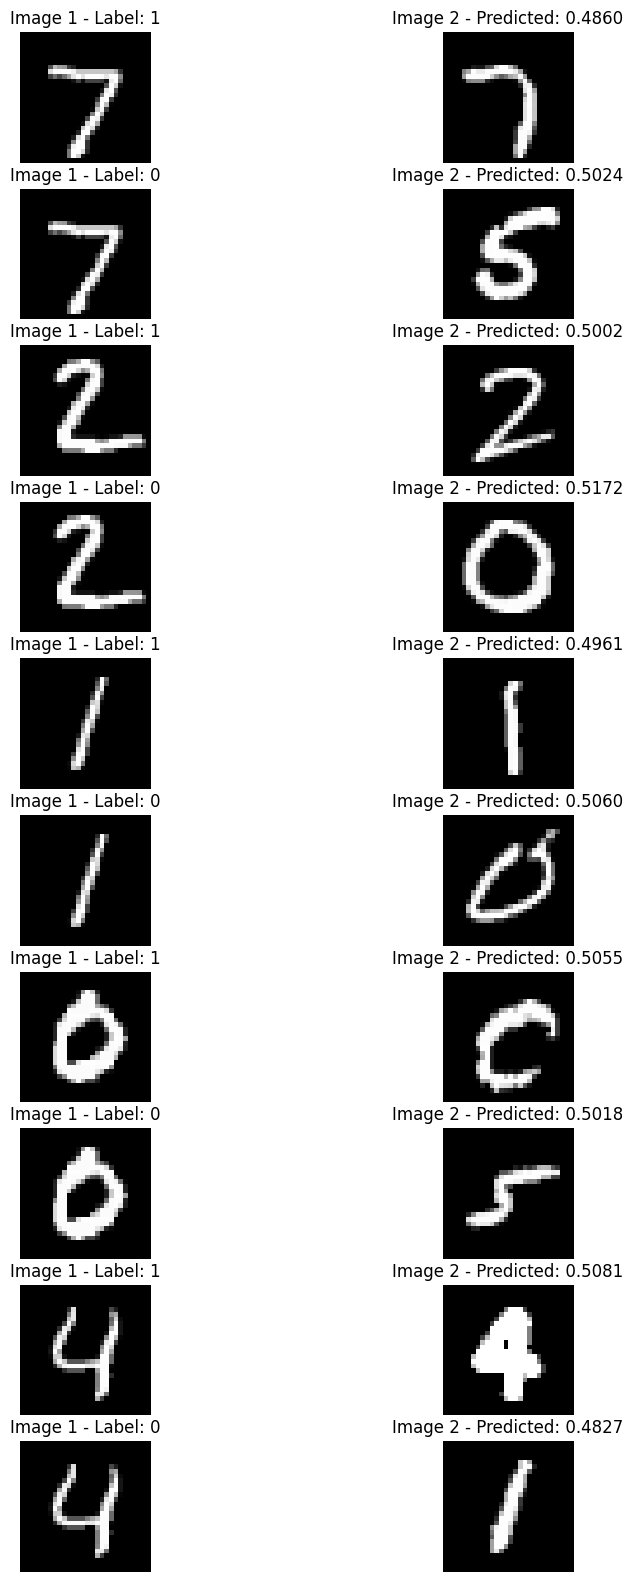

In [95]:
import matplotlib.pyplot as plt

def visualize_predictions(siamese_network, test_pairs, test_pair_labels, num_pairs=10):
    
    preds = siamese_network.predict([test_pairs[:, 0], test_pairs[:, 1]])
    
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 20))
    
    for i in range(num_pairs):
        axes[i, 0].imshow(test_pairs[i, 0], cmap="gray")
        axes[i, 0].set_title(f"Image 1 - Label: {test_pair_labels[i]}")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(test_pairs[i, 1], cmap="gray")
        axes[i, 1].set_title(f"Image 2 - Predicted: {preds[i][0]:.4f}")
        axes[i, 1].axis('off')
    
    plt.show()

visualize_predictions(siamese_network, test_pairs, test_pair_labels)
